# EMPJ Paper reproduction

All code necessary to simulate the figures in the accompanying paper.

In [1]:
%matplotlib notebook

## Non-standard packages
# autograd: https://github.com/HIPS/autograd
import autograd.numpy as np
from autograd import elementwise_grad as egrad

# Some self-written custom packages, which you can download here: https://github.com/elipollock/EMPJ
# A helper function to list combinations of parameters:
from helpers import param_list_perms_2
# The "JazNet" class, which makes it easy to work with RNNs:
import JazNets.JazNet as JazNet

#import numpy as np
import numpy.random as npr
from numpy.linalg import svd as SVD
from numpy.linalg import eigvals as eigvals

import matplotlib.pyplot as plt
from matplotlib.mlab import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

import time

# Set the size of the figures
mpl.rcParams['figure.dpi'] = 100

### Figure 1

Framework figure (no simulation)

### Figure 2
Show the basic attractor + changing the fixed points

In [157]:
# First, define half of a 2-D ring in high-D space. Then solve the linear equations for the weight matrix

# Make sines and cosines
k = 64
th = np.linspace(-np.pi, np.pi, k) ###################################
x = np.cos(th)
y = np.sin(th)


# Project into high dimension
N = 400
def gram_schmidt(vectors):
    basis = []
    for v in vectors.T:
        w = v - np.sum( np.dot(v,b)*b  for b in basis )
        if (w > 1e-10).any():  
            basis.append(w/np.linalg.norm(w))
    return np.array(basis).T

proj_vecs = gram_schmidt(npr.randn(N,2))  * 12  ################### ORTHOGONALIZATION
#proj_vecs = npr.randn(N,2)
acts = np.dot(proj_vecs, np.vstack((x,y)))
tangs = np.dot(proj_vecs, np.vstack((-y,x)))
tangs = tangs/np.linalg.norm(tangs, axis=0)


tau = .05

def lambda_fun(x):
    omega = 6
    return 0.1*(omega*np.sin(omega*x))

def phi(x):
    return np.tanh(x)


lam1s = 1/tau + lambda_fun(th)


Uts = [tangs[:,i] for i in range(k)]
As = [np.dot(Uts[i], np.diag(np.squeeze(egrad(phi)(acts[:,i])))) for i in range(k)]
Bs = [tau * lam1s[i] * Uts[i] for i in range(k)]

A = np.row_stack(As)
B = np.row_stack(Bs)


A = A + np.random.randn(A.shape[0], A.shape[1])*1e-6 

W = np.linalg.lstsq(A, B, rcond=-1)[0]

out_array = np.linalg.lstsq(phi(acts).T, np.vstack((x,y)).T, rcond=-1)[0]



.........................


<IPython.core.display.Javascript object>


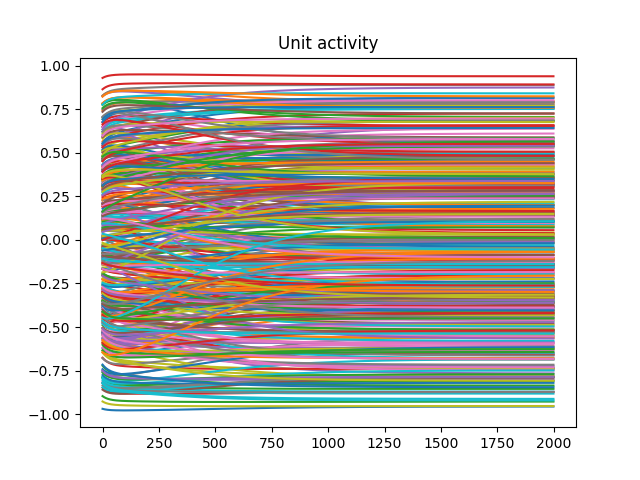

C:\Users\Eli\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


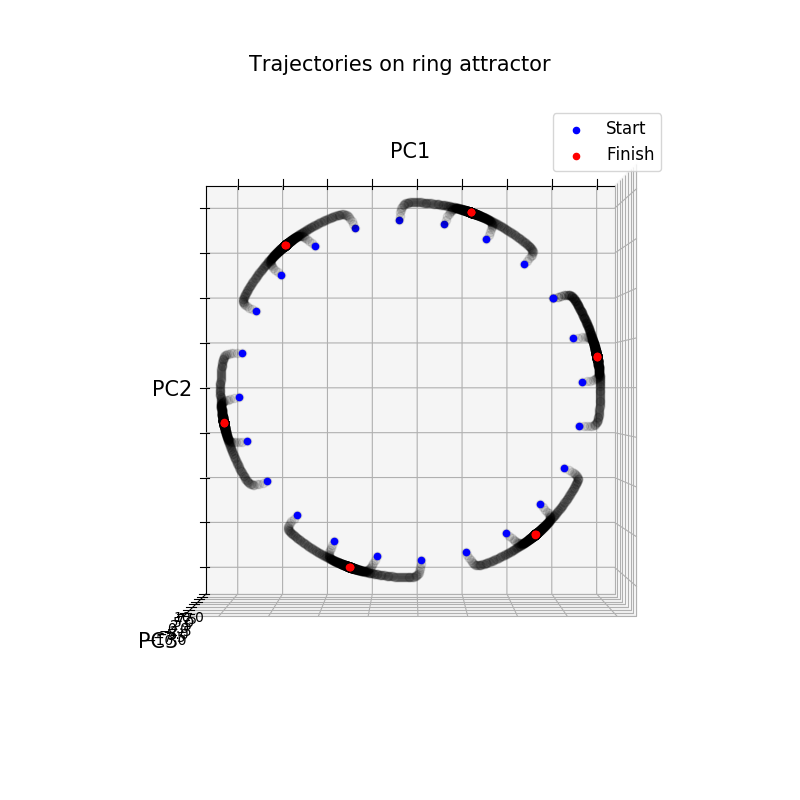

<IPython.core.display.Javascript object>


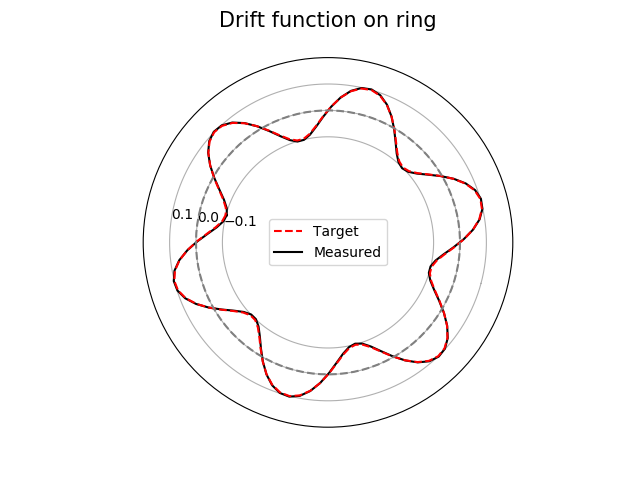

In [158]:
############### Create RNN, and test

p = JazNet.create_parameters()
p['network_size'] = N
p['g'] = 0
p['bias_scale'] = 0
p['out_scale'] = 0
p['init_act_scale'] = .01
p['test_trials'] = 10
p['dt'] = 0.005
p['tau'] = 0.05
p['noise_std'] = 0 #np.sqrt(p['dt'])*10
rnn = JazNet.RNN(p,2,2)

rnn.rnn_par['rec_weights'] = W
rnn.rnn_par['out_weights'] = out_array
###### USE ONLY IF YOU WANT TO SET THE RNN INPUT WEIGHTS
rnn.rnn_par['inp_weights'] = proj_vecs.T


randvec = npr.randn(400)

################# Simulate trajectories and show

def view_ring(rnn, delay, dsec, numthetas=100):

    d = int(dsec/rnn.p['dt'])
    
    rnn_noise = rnn.p['noise_std']
    #rnn.p['noise_std']= 0

    theta = np.linspace(-np.pi, np.pi, num=numthetas) +np.pi/(numthetas-1)
    xvals = np.cos(theta)
    yvals = np.sin(theta)

    X = []
    activities=[]
    theta_hat=[]
    
    Gt = []
    G=[]
    G_noise=[]
    
    for i in range(len(theta)):
        rnn.act = np.dot(rnn.rnn_par['inp_weights'].T, np.vstack((np.cos(theta[i]),np.sin(theta[i])))).T * .9
        #rnn.initialize_act()
        #rnn.act = np.zeros(rnn.act.shape)
        
        #inps = np.zeros((int(delay/rnn.p['dt']),2))
        inps = npr.randn(int(delay/rnn.p['dt']),2)*rnn_noise*0
        #inps[0:10,0] = np.cos(theta[i])
        #inps[0:10,1] = np.sin(theta[i])
        
        output, act = rnn.run(inps, record_flag=1)

        X.append(act)
        
        activities.append(act)
        print('.', end="")
    print('')
    rnn.p['noise_std']= rnn_noise
    
    plt.figure()
    plt.plot(np.tanh(X[0]))
    plt.title('Unit activity')
    
    X = np.vstack(X)
    pca =  PCA(X)

    
    fig=plt.figure(figsize=[8,8])
    ax = fig.add_subplot(111, projection='3d')
    traj_idx = np.arange(d,int(delay/rnn.p['dt']),10)
    for i in range(len(theta)):
        act = activities[i]
        proj = pca.project(act)
        traj = proj[:,0:3]
        #c = [abs(xvals[i]),0,abs(yvals[i])]
        c = [0,0,0]
        #ax.plot3D(traj[:,0],traj[:,1],traj[:,2],'o',color=c,alpha=0.1)
        ax.plot3D(traj[traj_idx,0],traj[traj_idx,1],traj[traj_idx,2],'o',color=c,alpha=.1)
        start = ax.scatter3D(traj[d,0],traj[d,1],traj[d,2],color=[0,0,1])
        finish = ax.scatter3D(traj[-1,0],traj[-1,1],traj[-1,2],color=[1,0,0])
        # Plotting the first start position:
        #if i==0:
        #    ax.scatter3D(traj[0,0],traj[0,1],traj[0,2],'bx', s=100)
            
    
    ax.set_xlabel('PC1', fontsize=15)
    ax.set_ylabel('PC2', fontsize=15)
    ax.set_zlabel('PC3', fontsize=15)
    ax.view_init(-90,90)

    ax.set_zlim3d([-10,10])
    
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    #ax.axes.zaxis.set_ticklabels([])

    
    plt.legend([start, finish], ['Start', 'Finish'], loc=(.7,.8), prop={'size': 12})

    return pca

############## Recover drift

def drift_recovery(rnn, proj_vecs, numthetas, showplots=1):

    
    theta = np.linspace(-np.pi, np.pi, num=numthetas) #+ np.pi/numthetas
    G=[]  # Drift at various values of theta
    
    rnn_noise = rnn.p['noise_std']
    #rnn.p['noise_std']= 0
    
    for i in range(len(theta)):
        rnn.act = np.dot(proj_vecs, np.vstack((np.cos(theta[i]),np.sin(theta[i])))).T
        
        inps = np.zeros((2,2))
    
        # Measure drift
        output = rnn.run(inps)[0]
        G.append((np.mod((np.arctan2(output[-1,1],output[-1,0])-
                  np.arctan2(output[-2,1],output[-2,0])) + np.pi, 2*np.pi) - np.pi)/rnn.p['dt'])
          
    G = np.array(G)
    rnn.p['noise_std']= rnn_noise

    if showplots:
        plt.figure()
        plt.plot(theta,G)
        plt.title('Drift function')
        plt.ylabel('Drift (rad/s)')
        plt.xlabel('$\Theta$')
        #plt.plot([-np.pi,np.pi],[0,0],'k--')
        plt.show()
        

    return G


########## Running everything

pca = view_ring(rnn, delay=10, dsec=.005, numthetas=25)
plt.title('Trajectories on ring attractor', fontsize=15)
plt.axis('equal')
plt.tight_layout()


numthetas=100
G = drift_recovery(rnn, proj_vecs, numthetas=numthetas, showplots=0)
th = np.linspace(-np.pi, np.pi, numthetas)
lambdas = lambda_fun(th - np.pi/numthetas)
g = np.cumsum(lambdas)*(2*np.pi/numthetas)
g = (g-np.mean(g))

offset = -np.pi/12
plt.figure()
ax = plt.subplot(111, projection='polar')
line1, = ax.plot(th, G, 'k')
line2, = ax.plot(th, g, '--', color=[1,0,0])
ax.plot(th, np.zeros(len(th)), '--', color=[.5,.5,.5])
ax.set_rmax(.2)
ax.set_rmin(-.5)
ax.set_rticks([-.1,0,.1])  # less radial ticks
#ax.set_thetagrids([0,60,120,180,240,300])
ax.set_thetagrids([])
ax.set_rlabel_position(180/np.pi * (np.pi-offset/2))  # get radial labels away from plotted line
ax.grid(True)
ax.set_theta_offset(offset)
plt.legend((line2, line1),('Target','Measured',),loc='center') 

ax.set_title('Drift function on ring',va='bottom', fontsize=15)
plt.show()

<IPython.core.display.Javascript object>


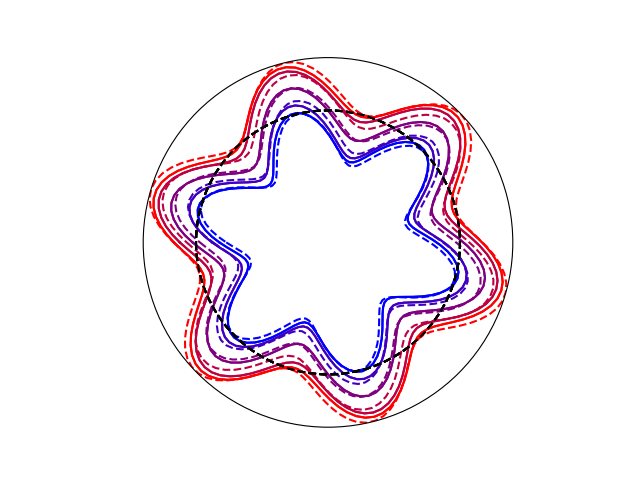

In [58]:

diagnostic_mode=0

noise = 6
k = 128
N=1000

plt.figure()
ax = plt.subplot(111, projection='polar')
for os in range(5):

    # First, define half of a ring in high-D space

    # Make sines and cosines
    th = np.linspace(0, 2*np.pi, k) ###################################
    x = np.cos(th)
    y = np.sin(th)

    # Project into high dimension
    #N = 1000
    proj_vecs = npr.rand(N,2)*2-1
    inp_vec = npr.rand(1,N)*2-1
    acts = np.dot(proj_vecs, np.vstack((x,y)))
    tangs = np.dot(proj_vecs, np.vstack((-y,x)))
    tangs = tangs/np.linalg.norm(tangs, axis=0)
    rads = acts/np.linalg.norm(acts, axis=0)
    inp_vec = inp_vec/np.linalg.norm(inp_vec)

    tau = .05

    def lambda_fun(x, omega=4):
        return -.1*(omega*np.cos(omega*th))

    def phi(x):
        #return np.tanh(x)
        return np.tanh(x)

    lam1s = 1/tau + lambda_fun(th, omega)
    lam2s = 1/tau - 7*np.ones(k)

    Uts = [np.row_stack((tangs[:,i], rads[:,i])) for i in range(k)]
    As = [np.dot(Uts[i], np.diag(np.squeeze(egrad(phi)(acts[:,i])))) for i in range(k)]
    Bs = [tau * np.dot(np.diag([lam1s[i], lam2s[i]]), Uts[i]) for i in range(k)]

    A = np.row_stack(As)
    B = np.row_stack(Bs)

    # First-order constraints
    for q in np.arange(1, omega):
        A = np.concatenate((A, np.atleast_2d(phi(acts[:,int(q*k/omega - k/(4*omega) + k/(8*omega)*os)]))))
        B = np.concatenate((B, np.atleast_2d(acts[:,int(q*k/omega - k/(4*omega) + k/(8*omega)*os)])))

    A = A + np.random.randn(A.shape[0], A.shape[1])/10**(noise) 

    W = np.linalg.lstsq(A, B, rcond=-1)[0]

    out_array = np.linalg.lstsq(phi(acts).T, np.vstack((x,y)).T, rcond=-1)[0]


    #########################################################3
    p = JazNet.create_parameters()
    p['network_size'] = N
    p['g'] = 0
    p['bias_scale'] = 0
    p['out_scale'] = 0
    p['init_act_scale'] = .01
    p['test_trials'] = 10
    p['dt'] = 0.005
    p['tau'] = 0.05
    p['noise_std'] = 0 #np.sqrt(2*p['dt'])/4
    rnn = JazNet.RNN(p,2,2)
    rnn.rnn_par['rec_weights'] = W
    rnn.rnn_par['out_weights'] = out_array
    rnn.rnn_par['inp_weights'] = inp_vec


    def drift_recovery(rnn, proj_vecs, numthetas, showplots=1):

        theta = np.linspace(-np.pi, np.pi, num=numthetas)
        theta_hat=[]  # Value of theta at end of trial
        G=[]  # Drift at various values of theta

        for i in range(numthetas):
            rnn.act = np.dot(proj_vecs, np.vstack((np.cos(theta[i]),np.sin(theta[i])))).T * 1

            inps = 0*np.ones((2,1))

            # Measure drift
            output = rnn.run(inps)[0]
            G.append((np.mod((np.arctan2(output[-1,1],output[-1,0])-
                      np.arctan2(output[-2,1],output[-2,0])) + np.pi, 2*np.pi) - np.pi)/rnn.p['dt'])


        G = np.array(G)
        if showplots:
            #plt.figure()
            #plt.subplot(1,diagnostic_mode+1,1)
            c = [os/4,0,1-os/4]
            plt.plot(theta,G, color=c)
            #plt.ylabel('Drift (radians/s)')
            #plt.xlabel('$\Theta$ (radians)')
            #plt.plot([-np.pi,np.pi],[0,0],'k--')
            plt.show()    
        return G


    numthetas=k
    G = drift_recovery(rnn, proj_vecs, numthetas=numthetas, showplots=1)
    th = np.linspace(-np.pi, np.pi, numthetas)
    #plt.plot(th[1:]-np.pi/numthetas, np.diff(G[i,:])/np.diff(th))
    lambdas = lambda_fun(th, omega) #0.2*(np.sin(4*th) + 2*np.sin(8*th))# .4*(np.sin(4*th))# + 2*np.sin(8*th))
    g = np.cumsum(lambdas)*(2*np.pi/numthetas)
    g = (g-np.mean(g)) - .1 + .05*os
    c = [os/4,0,1-os/4]
    #plt.plot(th, g, '--', color=c)
    #plt.plot(th,lambdas,'--')
    #plt.plot(th,np.zeros(np.size(th)),'k--')

    #plt.figure()
    ax.plot(th, G, color=c)
    ax.plot(th, g, '--', color=c)
    ax.plot(th, np.zeros(len(th)), 'k--')
    ax.set_rmax(.2)
    ax.set_rmin(-.5)
    ax.set_rticks([])  # less radial ticks
    #ax.set_thetagrids([0,60,120,180,240,300])
    ax.set_thetagrids([])
    #ax.set_rlabel_position(180/np.pi * (np.pi-offset/2))  # get radial labels away from plotted line
    ax.grid(True)
    #ax.set_theta_offset(offset)


    #ax.set_title('Drift function on ring',va='bottom', fontsize=15)
    plt.show()

    if diagnostic_mode:
        errnorm = []
        for i in range(np.shape(As)[0]):
            errnorm.append(np.linalg.norm(np.dot(As[i],W)-Bs[i]))
        plt.subplot(1,2,2)
        plt.plot(errnorm, color=c)
        plt.title('Noise: %g, k: %g, N: %g' % (noise, k, N))


### Figure 3

Show that it implements the right DDM (bias/variance tradeoff)

In [140]:
def G_sin(x, N):
    return np.sin(N*x)

def G_sawtooth(x,N):
    return -np.mod(x, 2*np.pi/N) * N/np.pi + 1

def DDProcess(x0,dt,T,beta,sigma,G,showplot=0,**G_args):
    from numpy.random import randn as dW
    x= np.reshape(x0,(1,-1)) # Necessary for using GP prediction
    q=[]
    for t in range(np.int(T/dt)):
        dx = beta*G(x,**G_args)*dt + sigma*np.sqrt(dt)*dW()
        x = np.mod(x+dx + np.pi, 2*np.pi) - np.pi
        q.append(x)
    q=np.squeeze(q)
    if showplot:
        plt.figure()
        plt.plot(np.arange(0,T,dt),q)
        plt.xlabel('Time (s)')
        plt.title('Drift-Diffusion process example')
    return x, q


def ErrorFun(dt, T, beta, sigma, G, showplot=0, showprog=0, ntrials=10, nthetas=10, **G_args):
    # Note that error WAS integrated over time, not just over initial values
    # Bias and variance are going to be computed only at the end of each trial
    # So the new error calculation is just bias+variance
    thetas = np.linspace(-np.pi, np.pi, num=nthetas)
    
    #error=0
    theta_hats = np.zeros((nthetas,ntrials))
    flips = np.zeros((nthetas,ntrials))
    
    for i in range(nthetas):
        theta = thetas[i]
        for j in range(ntrials):
            theta_hat, time_series = DDProcess(theta,dt=dt,T=T,beta=beta,sigma=sigma,G=G,**G_args)
            theta_hats[i,j] = theta_hat
            flips[i,j] = (np.sum(np.abs(np.diff(time_series))>(.9*2*np.pi)) + 
                        np.int(np.abs(theta - time_series[0])>(.9*2*np.pi))) & 0x1 # Check if it's crossed an odd number of times
            #error += sum((np.mod(time_series-theta + np.pi, 2*np.pi)-np.pi)**2)
        if showprog:
            print('.',end="")
    if showprog:
        print('')
        
    
    guessmeans = (np.arctan2(np.sum(np.sin(theta_hats),1),np.sum(np.cos(theta_hats),1)))   
    biases = np.abs(thetas-guessmeans)
    biases = np.abs(biases - 2*np.pi*(biases>np.pi))
    
    variances = np.var(theta_hats + 2*np.pi * flips * ((theta_hats<0)*2-1),1)
    VARIANCE = np.mean(variances)
    BIAS2 = np.mean(biases**2)
    
    #print(VARIANCE)
    #print(BIAS2)
    
    error = VARIANCE + BIAS2
    #error = np.sqrt(error/(ntrials*nthetas*T/dt))
    #print(error)
    if showplot:
        plt.figure()
        plt.plot(thetas, [th for th in theta_hats],'k.',alpha=0.1)
        plt.xlabel('$\Theta$')
        plt.ylabel('$\hat{\Theta}$')
        plt.title('func=%s, sigma = %g, T= %g, beta=%g, N=%g' % (G.__name__,sigma,T,beta,G_args['N']))

    return error, VARIANCE, BIAS2, variances, biases, theta_hats



def OptGridSearch(G_func, sigmas, Ts, betas, Ns, dt, ntrials=10, nthetas=10):
    
    errormats=[]
    varmats=[]
    biasmats=[]
    f=0
    for sigma in sigmas:
        f+=1
        #plt.figure(f)
        for T in Ts:
            errormat=np.zeros((len(betas),len(Ns)))
            varmat=np.zeros((len(betas),len(Ns)))
            biasmat=np.zeros((len(betas),len(Ns)))
            thetahatsmats=[]
            i=0
            for beta in betas:
                j=0
                for N in Ns:
                    error, VAR, BIAS2, variances, biases, theta_hats = ErrorFun(dt=dt, T=T, beta=beta, sigma=sigma, G=G_func, 
                                                         ntrials=ntrials, nthetas=nthetas, N=N, showplot=0)
                    errormat[i,j]=error
                    varmat[i,j]=VAR
                    biasmat[i,j]=BIAS2
                    thetahatsmats.append(theta_hats)
                    
                    #plt.figure(f)
                    #plt.plot(np.sqrt(variances), biases, 'o', color=[j/(len(Ns)-1),0,1-j/(len(Ns)-1)], alpha=.1)
                    #plt.plot(np.sqrt(VAR), np.sqrt(BIAS2), 'o', MarkerSize=10,
                    #         MarkerEdgeWidth=3, MarkerEdgeColor='k', 
                    #         color=[j/(len(Ns)-1),0,1-j/(len(Ns)-1)], alpha=1)
                    print('.',end="")
                    j+=1
                print('')
                i+=1

            errormats.append(errormat)
            varmats.append(varmat)
            biasmats.append(biasmat)
            
            #plt.figure()
            #plt.imshow(errormat)
            #plt.xticks(range(len(Ns)),Ns)
            #plt.yticks(range(len(betas)),betas)
            #plt.xlabel('N')
            #plt.ylabel('Beta')
            #plt.title('func= %s, sigma = %g, T= %g' % (G_func.__name__,sigma,T))
            #plt.colorbar()
            #plt.show()
            
            
            #plt.figure(1)
            #plt.xlim([0,1.5])
            #plt.ylim([0,1.5])
    return errormats,varmats,biasmats,thetahatsmats
        


In [141]:

def make_RNN(omega, beta, sigma):
    # Make sines and cosines
    k = 64
    th = np.linspace(0, 2*np.pi, k) ###################################
    x = np.cos(th)
    y = np.sin(th)

    # Project into high dimension
    N = 400
    def gram_schmidt(vectors):
        basis = []
        for v in vectors.T:
            w = v - np.sum( np.dot(v,b)*b  for b in basis )
            if (w > 1e-10).any():  
                basis.append(w/np.linalg.norm(w))
        return np.array(basis).T

    proj_vecs = gram_schmidt(npr.randn(N,2))  * 12  ################### ORTHOGONALIZATION
    #proj_vecs = npr.randn(N,2)
    acts = np.dot(proj_vecs, np.vstack((x,y)))
    tangs = np.dot(proj_vecs, np.vstack((-y,x)))
    tangs = tangs/np.linalg.norm(tangs, axis=0)

    tau = .05

    def lambda_fun(x):
        return beta*(omega*np.cos(omega*x))

    def phi(x):
        #return np.tanh(x)
        return np.tanh(x)

    lam1s = 1/tau + lambda_fun(th)

    Uts = [tangs[:,i] for i in range(k)]
    As = [np.dot(Uts[i], np.diag(np.squeeze(egrad(phi)(acts[:,i])))) for i in range(k)]
    Bs = [tau * lam1s[i] * Uts[i] for i in range(k)]

    A = np.row_stack(As)
    B = np.row_stack(Bs)

    A = A + np.random.randn(A.shape[0], A.shape[1])*1e-6 ################################## ADDING NOISE, TEMPORARY

    W = np.linalg.lstsq(A, B, rcond=-1)[0]

    out_array = np.linalg.lstsq(phi(acts).T, np.vstack((x,y)).T, rcond=-1)[0]

    ############### Create RNN

    p = JazNet.create_parameters()
    p['network_size'] = N
    p['g'] = 0
    p['bias_scale'] = 0
    p['out_scale'] = 0
    p['init_act_scale'] = .01
    p['test_trials'] = 10
    p['dt'] = 0.005
    p['tau'] = 0.05
    p['noise_std'] = sigma*p['tau']/np.sqrt(p['dt']) # * np.linalg.norm(proj_vecs[:,0])
    rnn = JazNet.RNN(p,2,2)

    rnn.rnn_par['rec_weights'] = W
    rnn.rnn_par['out_weights'] = out_array
    ###### USE ONLY IF YOU WANT TO SET THE RNN INPUT WEIGHTS
    rnn.rnn_par['inp_weights'] = proj_vecs.T
    
    return rnn



def RNN_sampler(rnn, delay, numtrials=10, numthetas=100):
    
    theta = np.linspace(-np.pi, np.pi, num=numthetas)

    theta_hats=np.zeros((numthetas, numtrials))
    flips = np.zeros((numthetas, numtrials))
    
    rnn_noise = rnn.p['noise_std']
    rnn.p['noise_std']=0
    
    
    for i in range(len(theta)):
        for j in range(numtrials):
            # Since input weights are same as proj_vecs, I can do the following:
            rnn.act = np.dot(rnn.rnn_par['inp_weights'].T, np.vstack((np.cos(theta[i]),np.sin(theta[i])))).T * 1

            #inps = np.zeros((int(delay/rnn.p['dt']),2))
            inps = npr.randn(int(delay/rnn.p['dt']),2)*rnn_noise
            output, act = rnn.run(inps, record_flag=1)
            
            time_series = np.arctan2(output[:,1],output[:,0])

            flips[i,j] = (np.sum(np.abs(np.diff(time_series))>(.9*2*np.pi)) + 
                        np.int(np.abs(theta[i] - time_series[0])>(.9*2*np.pi))) & 0x1 # Check if it's crossed an odd number of times
            theta_hats[i,j] = time_series[-1]
        print('.', end="")
    print('')
    rnn.p['noise_std']= rnn_noise
    
    
    guessmeans = (np.arctan2(np.sum(np.sin(theta_hats),1),np.sum(np.cos(theta_hats),1)))   
    biases = np.abs(theta-guessmeans)
    biases = np.abs(biases - 2*np.pi*(biases>np.pi))
    
    variances = np.var(theta_hats + 2*np.pi * flips * ((theta_hats<0)*2-1),1)
    VARIANCE = np.mean(variances)
    BIAS2 = np.mean(biases**2)
    
    error = VARIANCE + BIAS2
    
    print(VARIANCE)
    print(BIAS2)
    
    #plt.figure()
    #plt.plot(theta, theta_hats, 'k.', alpha=.1)


    return error, VARIANCE, BIAS2, theta_hats


This part is the full simulation, and takes some minutes to run.

In [143]:
def RNN_DDM_comparison(T, beta, sigma, Ns, ntrials, nthetas=18):
    ddm_errormats, ddm_varmats, ddm_biasmats, ddm_thetahats = OptGridSearch(G_func=G_sin, sigmas=[sigma], betas=[beta], 
                              Ts=[T], dt=.05, ntrials=ntrials, Ns=Ns, nthetas=nthetas)
    
    ddm_var = np.squeeze(ddm_varmats[0])
    ddm_bias2 = np.squeeze(ddm_biasmats[0])
    
    rnn_var=[]
    rnn_bias2=[]
    rnn_thetahats = []
    for i in range(len(Ns)):
        rnn = make_RNN(omega=Ns[i], beta=beta, sigma=sigma)    
        error, VARIANCE, BIAS2, theta_hats = RNN_sampler(rnn=rnn, delay=T, numtrials=ntrials, numthetas=nthetas)
        rnn_var.append(VARIANCE)
        rnn_bias2.append(BIAS2)
        rnn_thetahats.append(theta_hats)
        
    return ddm_var, ddm_bias2, rnn_var, rnn_bias2, ddm_thetahats, rnn_thetahats
        
ddm_var, ddm_bias2, rnn_var, rnn_bias2, ddm_thetahats, rnn_thetahats = RNN_DDM_comparison(T=15, 
                                            beta=0.2, sigma=.2, Ns=[2,4,6,8,0], ntrials=30, nthetas=18)

.....
..................
0.12424883471167229
0.846159257860261
..................
0.19314425697192963
0.17768023164871863
..................
0.4130516519452134
0.1349254198521933
..................
3.8873508804909824
1.5633955803404906
..................
0.3545500206399556
0.18142778360965753


<IPython.core.display.Javascript object>


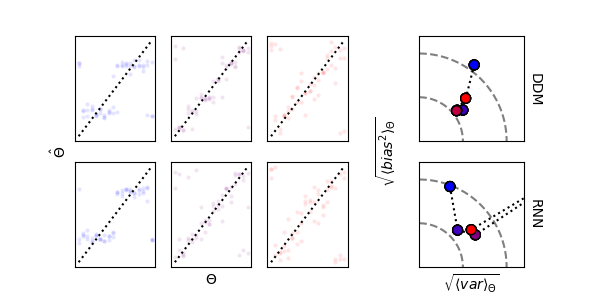

In [144]:
########### Left small panels showing the 
nthetas=rnn_thetahats[0].shape[0]
thetas = np.linspace(-np.pi, np.pi, num=nthetas)
fig = plt.figure(figsize=[6,3])

for i in range(3):
    s = fig.add_subplot(2,5,i+1)
    s.plot(thetas, ddm_thetahats[i*2], '.', c=[i/2,0,1-i/2, .1], MarkerEdgeWidth=0)
    plt.xticks([])
    plt.yticks([])
    
    plt.plot(thetas,thetas,'k:')
    
    s = fig.add_subplot(2,5,i+6)

    plt.plot(thetas, rnn_thetahats[i*2], '.', c=[i/2,0,1-i/2, .1], MarkerEdgeWidth=0)
    plt.xticks([])
    plt.yticks([])
    
    plt.plot(thetas,thetas,'k:')
    if i==1:
        plt.xlabel('$\Theta$')


fig.add_subplot(121, frameon=False)
plt.ylabel('$\hat{\Theta}$')
plt.xticks([])
plt.yticks([])



########## Right side; bias-variance plots
Ns = [2,4,6,8,0]
c = np.zeros((len(Ns),3))
c[:,0] = np.arange(0,len(Ns))/(len(Ns)-1)
c[:,2] = 1-np.arange(0,len(Ns))/(len(Ns)-1)

fig.add_subplot(2,3,3)

plt.plot(np.sqrt(ddm_var), np.sqrt(ddm_bias2), 'k:', zorder=0) 
for i in range(len(Ns)):
    plt.scatter(np.sqrt(ddm_var), np.sqrt(ddm_bias2), c=c, edgecolors='k', s=50, linewidth=1)
th = np.linspace(np.pi/2,0,50)
x = np.cos(th)
y = np.sin(th)
plt.plot(x,y,'k--', alpha=.5, zorder=0)
plt.plot(.5*x,.5*y,'k--', alpha=.5, zorder=0)
plt.xticks([])
plt.yticks([])

plt.axis('square')
plt.xlim([0,1.2])
plt.ylim([0,1.2])

fig.add_subplot(2,3,6)
plt.plot(np.sqrt(rnn_var), np.sqrt(rnn_bias2), ':', c='k', zorder=0)
for i in range(len(Ns)):
    plt.scatter(np.sqrt(rnn_var), np.sqrt(rnn_bias2), c=c, edgecolors='k', s=50, linewidth=1)
    
th = np.linspace(np.pi/2,0,50)
x = np.cos(th)
y = np.sin(th)
plt.plot(x,y,'k--', alpha=.5, zorder=0)
plt.plot(.5*x,.5*y,'k--', alpha=.5, zorder=0)
plt.xticks([])
plt.yticks([])

plt.axis('square')
plt.xlim([0,1.2])
plt.ylim([0,1.2])

fig.add_subplot(1,3,3, frameon=False)
plt.xticks([])
plt.yticks([])
plt.xlabel(r'$\sqrt{\langle var \rangle _{\Theta}}$')#, fontsize=15)
plt.ylabel(r'$\sqrt{\langle bias^2 \rangle _{\Theta}}$')#, fontsize=15)
#plt.yticks(fontsize=10)
#plt.xticks(fontsize=10)

#plt.tight_layout()

fig.text(0.88, 0.72, 'DDM', rotation=270)
fig.text(0.88, 0.3, 'RNN', rotation=270)



### Figure 4

Input control

............
............
............
............
............


<IPython.core.display.Javascript object>


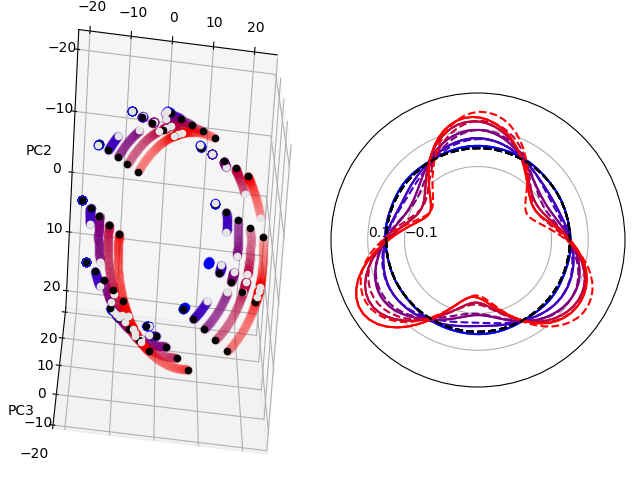

[0.0, 0, 1.0]
[0.25, 0, 0.75]
[0.5, 0, 0.5]
[0.75, 0, 0.25]
[1.0, 0, 0.0]


In [108]:
T=1000
k = 50
axes = []
inp_levels=[0,.5,1,1.5,2]
noise=6
dec=1
ic=6
    

# First, define half of a ring in high-D space

# Make sines and cosines
th = np.linspace(0, 2*np.pi, k) ###################################
x = np.cos(th)
y = np.sin(th)

# Project into high dimension
N = 400
def gram_schmidt(vectors):
    basis = []
    for v in vectors.T:
        w = v - np.sum( np.dot(v,b)*b  for b in basis )
        if (w > 1e-10).any():  
            basis.append(w/np.linalg.norm(w))
    return np.array(basis).T

proj_vecs = gram_schmidt(npr.randn(N,2))  * 8  ################### ORTHOGONALIZATION
inp_vec = npr.rand(1,N)*2-1
inp_vec = inp_vec/np.linalg.norm(inp_vec)
acts = np.dot(proj_vecs, np.vstack((x,y)))
tangs = np.dot(proj_vecs, np.vstack((-y,x)))
tangs = tangs/np.linalg.norm(tangs, axis=0)
rads = acts/np.linalg.norm(acts, axis=0)


tau = .05

def lambda_fun(x, omega=3):
    return -.1*(omega*np.cos(omega*th))

def phi(x):
    #return np.tanh(x)
    return np.tanh(x)

lam1s = 1/tau + lambda_fun(th)
lam2s = 1/tau - 7*np.ones(k)
lam3s = 1/tau - dec*np.ones(k)
Uts = [np.row_stack((tangs[:,i], rads[:,i], inp_vec)) for il in inp_levels for i in range(k)]
As = [np.dot(Uts[i], np.diag(np.squeeze(egrad(phi)(acts[:,i]+ic*il*inp_vec)))) for il in inp_levels for i in range(k)]
Bs = [tau * np.dot(np.diag([il*(lam1s[i]-1/tau)+1/tau, lam2s[i], lam3s[i]]), Uts[i]) for il in inp_levels for i in range(k)]

A = np.row_stack(As)
B = np.row_stack(Bs)

A = A + np.random.randn(A.shape[0], A.shape[1])/10**(noise) ################################## ADDING NOISE, TEMPORARY
#B = B + np.random.randn(B.shape[0], B.shape[1])/10**(10)

W = np.linalg.lstsq(A, B, rcond=-1)[0]

out_array = np.linalg.lstsq(phi(acts).T, np.vstack((x,y)).T, rcond=-1)[0]


#########################################################3
p = JazNet.create_parameters()
p['network_size'] = N
p['g'] = 0
p['bias_scale'] = 0
p['out_scale'] = 0
p['init_act_scale'] = .01
p['test_trials'] = 10
p['dt'] = 0.005
p['tau'] = 0.05
p['noise_std'] = 0 #np.sqrt(2*p['dt'])/4
rnn = JazNet.RNN(p,2,2)
rnn.rnn_par['rec_weights'] = W
rnn.rnn_par['out_weights'] = out_array
rnn.rnn_par['inp_weights'] = inp_vec

def view_ring(rnn, delay, dsec, numthetas=100, offset = 0):

    d = int(dsec/rnn.p['dt']) #inps_and_targs['targ_idx'][0] 
    # This should be when the system is settled onto the ring. Choose wisely

    rnn_noise = rnn.p['noise_std']
    #rnn.p['noise_std']= 0

    theta = np.linspace(-np.pi, np.pi, num=numthetas) + offset #np.pi/numthetas
    xvals = np.cos(theta)
    yvals = np.sin(theta)
    #inp_levels = [0,1,2,3,4]

    X = []
    activities=[]
    theta_hat=[]

    Gt = []
    G=[]
    G_noise=[]

    for il in inp_levels:
        for i in range(numthetas):
            rnn.act = ic*il*inp_vec + np.dot(proj_vecs, np.vstack((np.cos(theta[i]),np.sin(theta[i])))).T * 1

            inps = ic*dec*tau*il*np.ones((T,1))

            output, act = rnn.run(inps, record_flag=1)

            X.append(act)

            activities.append(act)
            print('.', end="")
        print('')
    rnn.p['noise_std']= rnn_noise

    X = np.vstack(X)
    pca =  PCA(X)

    fig=plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    for i in range(np.shape(activities)[0]):
        act = activities[i]
        proj = pca.project(act)
        traj = proj[:,0:3]
        c = [np.floor(i/numthetas)/(len(inp_levels)-1),0,1-np.floor(i/numthetas)/(len(inp_levels)-1)]
        #c = [abs(xvals[np.mod(i,numthetas)]),0,abs(yvals[np.mod(i,numthetas)])]
        #ax.plot3D(traj[:,0],traj[:,1],traj[:,2],'o',color=c,alpha=0.1)
        ax.plot3D(traj[d::10,0],traj[d::10,1],traj[d::10,2],'o',color=c,alpha=0.05)
        start = ax.scatter3D(traj[d,0],traj[d,1],traj[d,2],color=[0,0,0])
        finish = ax.scatter3D(traj[-1,0],traj[-1,1],traj[-1,2],color=[.9,.9,.9])

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.view_init(-90,90)
    #plt.legend([start, finish], ['Start', 'Finish'], loc=(.7,.8), prop={'size': 12})
    plt.tight_layout()

    return pca, ax


def drift_recovery(rnn, proj_vecs, numthetas, showplots=1):

    #inp_levels=[0,1,2,3,4]
    theta = np.linspace(-np.pi, np.pi, num=numthetas)
    theta_hat=[]  # Value of theta at end of trial
    G=[]  # Drift at various values of theta

    for il in inp_levels:
        for i in range(numthetas):
            rnn.act = ic*il*inp_vec + np.dot(proj_vecs, np.vstack((np.cos(theta[i]),np.sin(theta[i])))).T * 1

            inps = ic*dec*tau*il*np.ones((2,1))

            # Measure drift
            output = rnn.run(inps)[0]
            G.append((np.mod((np.arctan2(output[-1,1],output[-1,0])-
                      np.arctan2(output[-2,1],output[-2,0])) + np.pi, 2*np.pi) - np.pi)/rnn.p['dt'])


    G = np.array(G)
    G = np.reshape(G,(len(inp_levels),numthetas))
    if showplots:
        #plt.figure()
        ax = plt.subplot(122, projection='polar')
        i=0
        for il in inp_levels:
            c = [il/max(inp_levels),0,1-il/max(inp_levels)]
            plt.plot(theta,G[i,:], color=c)
            i+=1
        #plt.ylabel('Drift (radians/s)')
        #plt.xlabel('$\Theta$ (radians)')
        #plt.plot([-np.pi,np.pi],[0,0],'k--')
        plt.show()    
    return G, ax

pca, ax1 = view_ring(rnn, delay=4, dsec=.005, numthetas=12, offset = 1*np.pi/18)

numthetas=100
G, ax2 = drift_recovery(rnn, proj_vecs, numthetas=numthetas, showplots=1)
th = np.linspace(-np.pi, np.pi, numthetas)
i=0
for il in inp_levels:
    #plt.plot(th[1:]-np.pi/numthetas, np.diff(G[i,:])/np.diff(th))
    lambdas = il*lambda_fun(th) #0.2*(np.sin(4*th) + 2*np.sin(8*th))# .4*(np.sin(4*th))# + 2*np.sin(8*th))
    g = np.cumsum(lambdas)*(2*np.pi/numthetas)
    g = (g-np.mean(g))
    c = [il/max(inp_levels),0,1-il/max(inp_levels)]
    #plt.plot(th, g, '--', color=c)
    #plt.plot(th,lambdas,'--')
    #plt.plot(th,np.zeros(np.size(th)),'k--')

    print(c)

    ax2.plot(th, G[i,:], color=c)
    ax2.plot(th, g, '--', color=c)
    ax2.plot(th, np.zeros(len(th)), 'k--')
    ax2.set_rmax(.3)
    ax2.set_rmin(-.5)
    ax2.set_rticks([-.1,.1])  # less radial ticks
    ax2.set_rlabel_position(180)
    #ax.set_thetagrids([0,60,120,180,240,300])
    #ax2.set_rgrids([-.1,.1])
    ax2.set_thetagrids([])
    i+=1

#errnorm = []
#for i in range(np.shape(As)[0]):
#    errnorm.append(np.linalg.norm(np.dot(As[i],W)-Bs[i]))
#plt.subplot(1,2,2)
#plt.plot(errnorm)
#plt.title('IC: %g, dec: %g, noise: %g' % (ic, dec, noise))
#fig = plt.gcf()
#fig.set_size_inches(2,1)

axes.append(ax1)

In [139]:
# Rotating the first panel
fig = plt.gcf()
ax = fig.axes[0]
ax.view_init(-70, -95)
ax.dist = 8
plt.show()

### Figure 5

Looking at higher dimensions

In [145]:


def phi_generator(num_phis, kappa, offset=0):
    phis = []

    for i in range(num_phis):
        def f(x, i=i):
            #return np.pi/2  - np.exp(kappa*np.cos(x - offset -  2*i*np.pi/num_phis))/np.exp(kappa)/2
            return np.exp(kappa*np.cos(x - offset -  2*i*np.pi/num_phis))/np.exp(kappa)/2

        phis.append(f)

    def phi_n(x):
        return x - offset

    phis.append(phi_n)
    return phis


def draw_sphere(ax, radius=1):
    k_az = 30
    k_el = 20
    k = k_az*k_el

    theta = np.linspace(0, 2*np.pi, k_az)
    phi = np.linspace(0, np.pi, k_el) - np.pi/2

    angles = param_list_perms_2(p1 = theta, p2 = phi)

    x = radius*np.cos(angles[:,0]) * np.cos(angles[:,1])
    y = radius*np.sin(angles[:,0]) * np.cos(angles[:,1])
    z = radius*np.sin(angles[:,1])

    ax.plot3D(x,y,z, 'b.', alpha=.1)
    ax.set_xlim([-1.2,1.2])
    ax.set_ylim([-1.2,1.2])
    ax.set_zlim([-1.2,1.2])
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    ax.set_zlabel('z', fontsize=16)
    


def ring_on_sphere(phis, radius=1, numthetas=64, thetas=[]):
    # Inputs:
    #     - List of n "phi" functions that give values of surface angles over sphere on a ring in terms of parameter theta
    #           ** NOTE: last phi function should just be phi(x) = x
    #     - A value for the radius of the sphere
    #     -Either:
    #        - numthetas: number of theta values from -pi to pi to create ring
    #        - thetas: array of values of theta, set by hand. Putting something here overrides the numthetas setting
    # Outputs:
    #     - x: projection onto the (n+1) dimensions in which the sphere is embedded, at all k values of theta ((n+1) x k)
    #     - v: tangent at each of those points (same size)

    if not len(thetas):
        thetas = np.linspace(-np.pi, np.pi, numthetas)
    n = len(phis)+1
    
    x = np.zeros((n, len(thetas))) # Coordinates of points
    v = np.zeros((n, len(thetas)))

    
    ########## ORIGINAL WAY: Guaranteed to have fixed radius, based on wikipedia for transforming spherical coordinates to cartesian
    ########## Downside: interference between overlapping tuning curves, due to recursive definition
    #for t in range(len(thetas)):
    #    for m in range(n-1):
    #        th = thetas[t]
    #        x[m, t] = radius * cos(phis[m](th)) * np.prod([sin(phis[j](th)) for j in range(m)]) 
    #        v[m, t] = radius * (np.sum([egrad(phis[j])(th)*x[m,t]/np.tan(phis[j](th)) for j in range(m)])
    #                    - egrad(phis[m])(th)*np.prod([sin(phis[j](th)) for j in range(m+1)]))
    #        
    #    x[n-1, t] = radius * np.prod([sin(phis[j](th)) for j in range(n-1)])
    #    v[n-1, t] = radius * np.sum([egrad(phis[j])(th)*x[n-1,t]/np.tan(phis[j](th)) for j in range(n-1)])
    
    ####### NEW WAY: Tuning curves defined independently; last two coordinates take whatever is left over
    ####### Downside: need to ensure that tuning curves do not sum to greater than 1 anywhere  
    for t in range(len(thetas)):
        th = thetas[t]
        for m in range(n-2):
            x[m,t] = radius * phis[m](th)
            v[m,t] = radius*egrad(phis[m])(th)
            
        x[n-2, t] = np.sqrt(radius**2 - np.linalg.norm(x[0:n-2,t])**2) * np.sin(th) 
        v[n-2, t] = x[n-2, t]/np.tan(th) - np.sin(th)**2/x[n-2,t] * np.sum([x[j,t]*egrad(phis[j])(th) for j in range(n-2)])
        x[n-1, t] = np.sqrt(radius**2 - np.linalg.norm(x[0:n-2,t])**2) * np.cos(th) 
        v[n-1, t] = -x[n-1, t]*np.tan(th) - np.cos(th)**2/x[n-1,t] * np.sum([x[j,t]*egrad(phis[j])(th) for j in range(n-2)])
        
    v = v/np.linalg.norm(v, axis=0)       
    
    return x, v




<IPython.core.display.Javascript object>


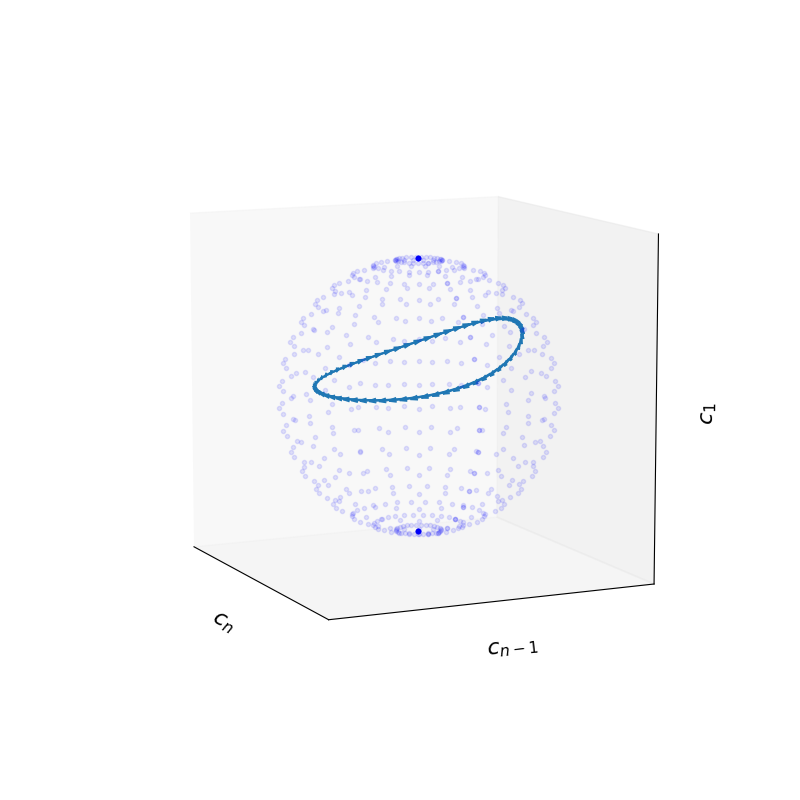

<IPython.core.display.Javascript object>


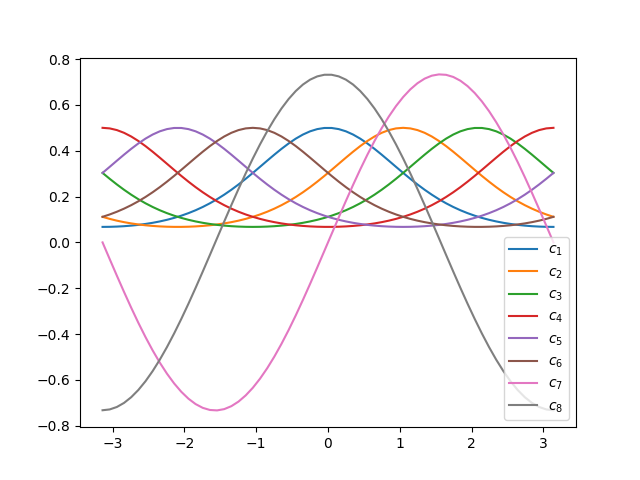

In [146]:
n=6
phis = phi_generator(num_phis=n, kappa=1, offset=0)

x,v = ring_on_sphere(phis, radius=1, thetas=[])


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(x[-2],x[-1],x[0], v[-2], v[-1], v[0], length=.2)

draw_sphere(ax, radius=1)
ax.set_xlabel('$c_n$')
ax.set_ylabel('$c_{n-1}$')
ax.set_zlabel('$c_1$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.view_init(10,-25)

plt.figure()
names = []
for i in range(x.shape[0]):
    plt.plot(np.linspace(-np.pi, np.pi, 64), x[i])
    names.append(('$c_{%d}$' % (i+1)))
plt.legend(names, loc='lower right')

In [147]:
def get_rnn(phis, omega=4, drift_amp=0.1, k=144, N=300, radius=10, sigma_reg=1e-3, showplots=1):
    th = np.linspace(-np.pi, np.pi, k)
    X,V = ring_on_sphere(phis, radius=1, numthetas = k)

    # Project into high dimension
    def gram_schmidt(vectors):
        basis = []
        for v in vectors.T:
            w = v - np.sum( np.dot(v,b)*b  for b in basis )
            if (w > 1e-10).any():  
                basis.append(w/np.linalg.norm(w))
        return np.array(basis).T

    proj_vecs = gram_schmidt(npr.randn(N,X.shape[0]))  * radius  ################### ORTHOGONALIZATION
    acts = np.dot(proj_vecs, X)
    tangs = np.dot(proj_vecs, V)
    tangs = tangs/np.linalg.norm(tangs, axis=0)

    tau = .05

    def lambda_fun(x):
        return -drift_amp*(omega*np.cos(omega*x))  ############## NORMALIZE BY ADDING FACTOR OF OMEGA

    def phi(x):
        #return np.tanh(x)
        return np.tanh(x)

    lam1s = 1/tau + lambda_fun(th)

    Uts = tangs.T
    As = [np.dot(Uts[i], np.diag(np.squeeze(egrad(phi)(acts[:,i])))) for i in range(k)]
    Bs = [tau * lam1s[i] * Uts[i] for i in range(k)]

    A = np.row_stack(As)
    B = np.row_stack(Bs)
    
    for f in range(2*omega):
        A = np.concatenate((A, np.atleast_2d(phi(acts[:,int(k*f/(2*omega))]))))
        B = np.concatenate((B, np.atleast_2d(acts[:,int(k*f/(2*omega))])))

    ####### TRIED SWITCHING ADDITION OF NOISE AND CONSTRAINTS. But it fails in the case of the 2d ring
    A = A + np.random.randn(A.shape[0], A.shape[1])*sigma_reg ################################## ADDING NOISE, TEMPORARY
    
    W = np.linalg.lstsq(A, B, rcond=-1)[0]

    #out_array = np.linalg.lstsq(phi(acts).T, np.vstack((x,y)).T, rcond=-1)[0]

    errnorm = []
    for i in range(k):
        errnorm.append(np.linalg.norm(np.dot(As[i],W)-Bs[i]))
    
    p = JazNet.create_parameters()
    p['network_size'] = N
    p['g'] = 0
    p['bias_scale'] = 0
    p['out_scale'] = 0
    p['init_act_scale'] = .01
    p['test_trials'] = 10
    p['dt'] = 0.005
    p['tau'] = 0.05
    p['noise_std'] = 0 #np.sqrt(2*p['dt'])/4
    rnn = JazNet.RNN(p,4,3)

    rnn.rnn_par['rec_weights'] = W
    #rnn.rnn_par['out_weights'] = npr.randn(N,3)  #### NOT READY YET
    ###### USE ONLY IF YOU WANT TO SET THE RNN INPUT WEIGHTS
    rnn.rnn_par['inp_weights'] = proj_vecs.T * .5
    
    if showplots:
        plt.figure()
        plt.plot(th, lambda_fun(th))
        g = np.cumsum(lambda_fun(th))
        g = (g-np.mean(g))*(2*np.pi/k)
        plt.plot(th, g, '--')
        
        plt.figure()
        plt.plot(errnorm)

        evals = eigvals(W)
        plt.figure()
        plt.plot(np.real(evals), np.imag(evals), 'o', alpha=0.5)
        plt.xlabel('Real part')
        plt.ylabel('Imaginary part')
        plt.title('Eigenvalues of weight matrix')
        plt.axis('equal')
        
    return rnn, proj_vecs


In [148]:
def decode_activity(acts, decoder_sin, decoder_cos):
    theta_hat = np.arctan2(acts.dot(decoder_sin), acts.dot(decoder_cos))
    return theta_hat

def get_decoders(phis, proj_vecs, showplots=0):
    numthetas=100
    X = ring_on_sphere(phis, numthetas= numthetas)[0]
    acts = np.dot(proj_vecs, X).T
    thetas = np.atleast_2d(np.linspace(-np.pi, np.pi, numthetas)).T

    sines = np.sin(thetas)
    coses = np.cos(thetas)

    decoder_sin = np.linalg.lstsq(acts, sines, rcond=-1)[0]
    decoder_cos = np.linalg.lstsq(acts, coses, rcond=-1)[0]
    
    if showplots:
        theta_hat = decode_activity(acts, decoder_sin, decoder_cos)
        plt.figure()
        plt.plot(thetas, theta_hat)
        plt.xlabel('Theta')
        plt.ylabel('Theta_hat')
        plt.title('RMSE = %g' % np.sqrt(np.mean((thetas[1:-2]-theta_hat[1:-2])**2)))
    
    return decoder_sin, decoder_cos



In [149]:
def analyze_ring(rnn, delay, dsec, numthetas=100, showplots=0):
    
    d = int(dsec/rnn.p['dt']) #inps_and_targs['targ_idx'][0] 
    # This should be when the system is settled onto the ring. Choose wisely
    
    rnn_noise = rnn.p['noise_std']
    #rnn.p['noise_std']= 0

    theta = np.linspace(-np.pi, np.pi - 2*np.pi/numthetas, num=numthetas)+np.pi/(numthetas-1)

    x = ring_on_sphere(phis, thetas = theta)[0]
    decoder_sin, decoder_cos = get_decoders(phis=phis, proj_vecs=proj_vecs, showplots=0)
    
    X = []
    activities=[]
    deviations = []
    
    for i in range(len(theta)):
        rnn.act = np.dot(proj_vecs, np.atleast_2d(x[:,i]).T).T * 1
        #rnn.act = np.dot(proj_vecs[:,1:3], np.atleast_2d(x[1:3,i]).T).T * .9 + 1 *(proj_vecs[:,0] * x[0,i]).T
        
        inps = np.zeros((int(delay/rnn.p['dt']),x.shape[0]))
        #inps[0:10,0] = np.cos(theta[i])
        #inps[0:10,1] = np.sin(theta[i])
        
        output, act = rnn.run(inps, record_flag=1)

        X.append(act)
        
        activities.append(act)
    #    print('.', end="")
    #print('')
    rnn.p['noise_std']= rnn_noise
    
    if showplots:
        plt.figure()
        plt.plot(np.tanh(X[0]))

        X = np.vstack(X)
        pca =  PCA(X)
        print('PCA done')

        fig=plt.figure(figsize=[8,8])
        ax = fig.add_subplot(111, projection='3d')

        fig2 = plt.figure()
        ax2 = fig2.add_subplot(111)
        #ax3 = fig2.add_subplot(122)
    
    traj_idx = np.arange(d,int(delay/rnn.p['dt']), 20)  # Downsample time series
    for i in range(len(theta)):
        ####################### Plot the pc's
        act = activities[i]
        
        if showplots:
            proj = pca.project(act)
            traj = proj[:,0:3]
            #c = [abs(xvals[i]),0,abs(yvals[i])]
            c = [0,0,0]
            #ax.plot3D(traj[:,0],traj[:,1],traj[:,2],'o',color=c,alpha=0.1)
            ax.plot3D(traj[traj_idx,0],traj[traj_idx,1],traj[traj_idx,2],'o',color=c,alpha=.1)
            start = ax.scatter3D(traj[d,0],traj[d,1],traj[d,2],color=[0,0,1])
            finish = ax.scatter3D(traj[-1,0],traj[-1,1],traj[-1,2],color=[1,0,0])
            #if i==0:
            #    ax.scatter3D(traj[0,0],traj[0,1],traj[0,2],'bx', s=100)
            
            
        ############################# Quantifying deviation of the trajectories from the ring
        reduced_act = act[traj_idx,:]   # Downsample activity
        theta_hat = decode_activity(reduced_act, decoder_sin, decoder_cos) # Decode theta
        #ax2.plot(theta_hat)
        
        x_hat, v_hat = ring_on_sphere(phis, thetas = theta_hat)  # Get what your position and direction of movement should be
        X_hat = np.dot(proj_vecs, x_hat) # Project into full dimensions
        X_error = np.linalg.norm(X_hat - reduced_act.T, axis=0)  # See how far you are from the ring
        deviations.append(np.mean(X_error))
        
        if showplots:
            ax2.plot(X_error, color= 'k', alpha=.5) #[i/(len(theta)-1),0,1-i/(len(theta)-1)])
        
        ####### Ignoring for now: comparing direction of movement to direction along ring at decoded position
        #V_hat = np.dot(proj_vecs, v_hat)
        #V_hat = V_hat/np.linalg.norm(V_hat, axis=0)
        #Xdiff = np.diff(reduced_act, axis=0).T
        #Xdiff = Xdiff/np.linalg.norm(Xdiff, axis=0)
        #q=np.zeros(Xdiff.shape[1])
        #for j in range(Xdiff.shape[1]):
        #    q[j] = np.abs(np.dot(Xdiff[:,j], V_hat[:,j]))
        #ax2.plot(q, color=[i/(len(theta)-1),0,1-i/(len(theta)-1)])
        #qq.append(min(q))
        
    deviation = np.mean(deviations)  
    
    if showplots:
        ax.set_xlabel('PC1', fontsize=15)
        ax.set_ylabel('PC2', fontsize=15)
        ax.set_zlabel('PC3', fontsize=15)
        ax.view_init(45,45)

        ax.set_zlim3d([-20,20])

        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.axes.zaxis.set_ticklabels([])

        ax.legend([start, finish], ['Start', 'Finish'], loc=(.7,.8), prop={'size': 12})

    return deviation





In [159]:
# Putting it all together

# phis = phi_generator(num_phis=4, kappa=2, offset=0)   # Get the higher dimensional functions that define the ring
# rnn, proj_vecs = get_rnn(phis=phis, omega=4, drift_amp=0.0, k=144, N=400, radius=12, sigma_reg=1e-3)  # Synthesize the rnn
# decoder_sin, decoder_cos = get_decoders(phis=phis, proj_vecs=proj_vecs, showplots=0)  # Get decoders
# deviation = analyze_ring(rnn, delay=5, dsec=.005, numthetas=20, showplots=1)  # Check deviation from various initial conditions
# print(deviation)

<IPython.core.display.Javascript object>


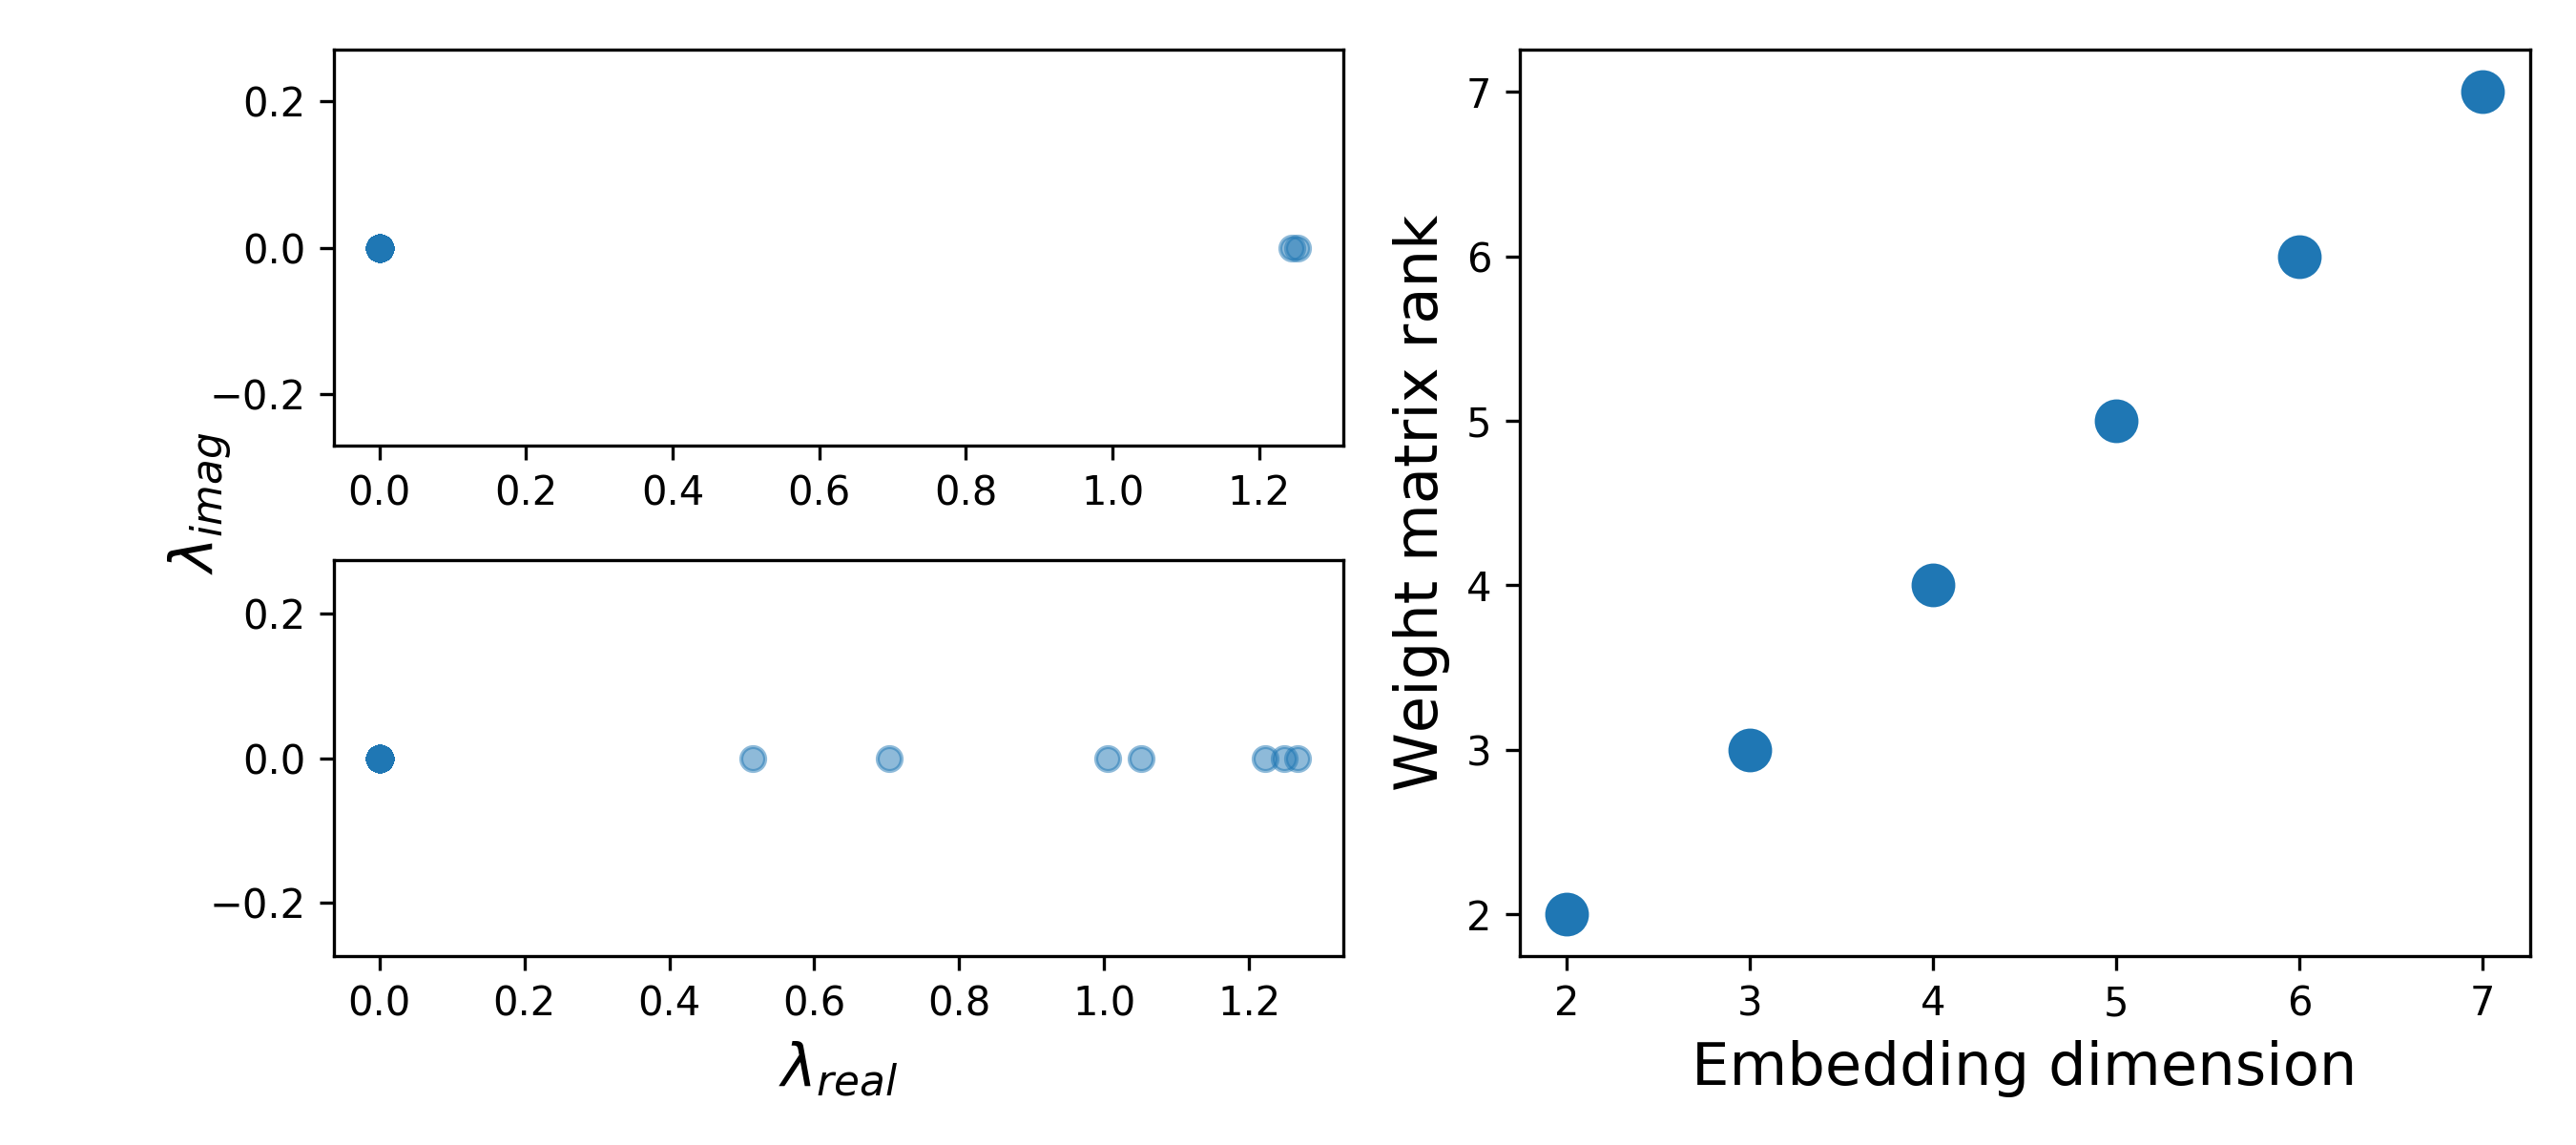

In [119]:
rank = []
ndims = np.array([0,1,2,3,4,5])
fig = plt.figure(figsize=(9,4))

for n in ndims:
    phis = phi_generator(num_phis=n, kappa=2, offset=0)
    rnn, proj_vecs = get_rnn(phis=phis, omega=n, drift_amp=0.1, k=144, N=400, radius=12, sigma_reg=1e-3, showplots=0)
    evals = eigvals(rnn.rnn_par['rec_weights'])
    rank.append(sum(evals>1e-6))
    
    if n==0:
        fig.add_subplot(2,2,1)
        plt.plot(np.real(evals), np.imag(evals), 'o', alpha=0.5)
        #plt.title('Eigenvalues of weight matrix', fontsize=15)
        plt.axis('equal')
        
    elif n==np.max(ndims):
        fig.add_subplot(2,2,3)
        plt.plot(np.real(evals), np.imag(evals), 'o', alpha=0.5)
        plt.xlabel('$\lambda_{real}$', fontsize=15)
        plt.axis('equal')
    
fig.add_subplot(1,2,1, frameon=False)
plt.xticks([])
plt.yticks([])
plt.ylabel('$\lambda_{imag}$', fontsize=15, labelpad=25)
fig.add_subplot(1,2,2)
plt.scatter(ndims+2, rank, s=100)
plt.xlabel('Embedding dimension', fontsize=15)
plt.ylabel('Weight matrix rank', fontsize=15)

plt.tight_layout()

In [152]:
kappas = [1,2,3,4,5,6,7,8]
ns = [0,1,2,3,4,5,6]
all_ring_lengths = []
for kappa in kappas:
    ring_length = []
    #plt.figure()
    for num_phis in ns:  #[(num_phis/np.pi)**2 * 1, 1,2,3,4,5,6,7,8,9,10,11]:

        phis = phi_generator(num_phis=num_phis, kappa=kappa)
        X = ring_on_sphere(phis, numthetas= 200)[0]

        #FI = np.sum((np.diff(X[:-2]))**2 / ((X[:-2,1:] + X[:-2,:-1])/2), axis=0)
        dl = np.linalg.norm(np.diff(X), axis=0)
        #plt.plot(dl)
        
        ring_length.append(np.sum(dl))
    
    all_ring_lengths.append(ring_length)
        

<IPython.core.display.Javascript object>


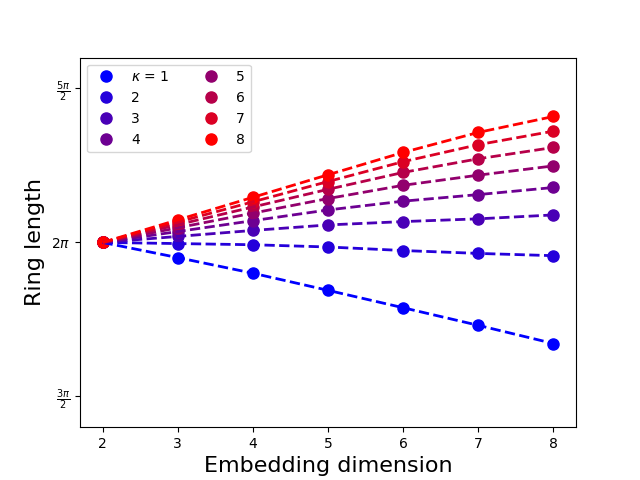

In [153]:
fig = plt.figure()
ax = fig.add_subplot(111)
c=0
for i in range(len(kappas)):
    plt.plot(np.array(ns)+2,all_ring_lengths[i], 'o', color=[c/(len(kappas)-1), 0, 1-c/(len(kappas)-1)],  MarkerSize=8)
    c+=1
c=0
for i in range(len(kappas)):    
    plt.plot(np.array(ns)+2,all_ring_lengths[i], '--', color=[c/(len(kappas)-1), 0, 1-c/(len(kappas)-1)],  LineWidth=2)
    c+=1
    
plt.yticks([1.5*np.pi, 2*np.pi, 2.5*np.pi])
ax.set_yticklabels([r'$\frac{3 \pi}{2}$', r'$2\pi$',r'$\frac{5 \pi}{2}$'])
plt.ylabel('Ring length', fontsize=16)
plt.xlabel(r'Embedding dimension', fontsize=16)
plt.ylim([1.4*np.pi, 2.6*np.pi])


plt.legend(['$\kappa$ = 1', '2', '3','4','5','6','7','8'], loc='best', ncol=2)

## Figure 6

In [154]:
def drift_recovery(rnn, proj_vecs, numthetas, drift_amp, showplots=1):

    def lambda_fun(x, drift_amp):
        return -drift_amp*(omega*np.cos(omega*x))  ############## NORMALIZE BY ADDING FACTOR OF OMEGA
    
    theta = np.linspace(-np.pi, np.pi, num=numthetas)
    G=[]  # Drift at various values of theta
    A=[]
    x,v = ring_on_sphere(phis, numthetas= numthetas)
    
    tangs = np.dot(proj_vecs, v)
    tangs = tangs/np.linalg.norm(tangs, axis=0)
    
    for i in range(len(theta)):
        rnn.act = np.dot(proj_vecs, np.atleast_2d(x[:,i]).T).T * 1
        inps = np.zeros((2,x.shape[0]))
    
        # Measure drift
        output, act = rnn.run(inps, record_flag=1)
        
        dx = act[-1] - act[-2]
        dx_norm = np.linalg.norm(dx)
        drift = np.dot(dx, tangs[:,i])/(rnn.p['dt']*np.linalg.norm(proj_vecs[:,0]))
        alignment = np.abs(drift/dx_norm)*(rnn.p['dt']*np.linalg.norm(proj_vecs[:,0]))
        
        A.append(alignment)
        G.append(drift)
    
    
    G = np.array(G)
    
    g = np.cumsum(lambda_fun(theta, drift_amp))
    g = (g-np.mean(g))*(2*np.pi/numthetas)
    
    G_error = np.sqrt(np.mean((g - G)**2))

    if showplots:
        plt.figure()
        plt.plot(theta, A)
        
        plt.figure()
        ax = plt.subplot(111, projection='polar')
        ax.plot(theta, G, 'k')
        ax.plot(theta, g, '--', color=[1,0,0])
        ax.plot(theta, np.zeros(len(theta)), '--', color=[.5,.5,.5])
        ax.set_rmax(.2)
        ax.set_rmin(-.5)
        ax.set_rticks([-.1,0,.1])  # less radial ticks
        #ax.set_thetagrids([0,60,120,180,240,300])
        ax.set_thetagrids([])
        offset=0
        ax.set_rlabel_position(180/np.pi * (np.pi-offset/2))  # get radial labels away from plotted line
        ax.grid(True)
        ax.set_theta_offset(offset)
        plt.legend(['Measured','Target'],loc='center')
    
    
    return G, G_error

#G, G_error=drift_recovery(rnn, proj_vecs, numthetas=200, drift_amp=0.1, showplots=1)
#print(G_error)



In [156]:
# Find deviation and error given different network sizes. Can use as examples for 6a

reps = 10

devs = np.zeros((1,1,1,6,reps))
gerrs = np.zeros((1,1,1,6,reps))

i=0
for num_phis in [4]:
    j=0
    for kappa in [2]:
        phis = phi_generator(num_phis=num_phis, kappa=kappa)
        m=0
        for omega in [4]:
            n=0
            for N in [100,200,300,400,500,600]:
                for drift_amp in [0.1]:
                    for sigma in  [1e-3]:
                        k=0
                        for rep in range(reps):
                            rnn, proj_vecs = get_rnn(phis=phis, omega=omega, drift_amp=drift_amp, 
                                                     k=144, N=N, radius=12, sigma_reg=sigma, showplots=0)
                            deviation = analyze_ring(rnn, delay=5, dsec=.005, numthetas=24, showplots=(rep==0))
                            G, G_error=drift_recovery(rnn, proj_vecs, numthetas=144, drift_amp=drift_amp, showplots=0)
                            devs[i,j,m,n,k] = deviation
                            gerrs[i,j,m,n,k] = G_error
                            k+=1
                n+=1
                print('.')
            m+=1
        j+=1
        #print('.', end="")
    i+=1
    #print('')
    
print('Done!')
                            

C:\Users\Eli\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>

PCA done


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\Eli\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in true_divide


.


<IPython.core.display.Javascript object>

PCA done


<IPython.core.display.Javascript object>

C:\Users\Eli\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

.


<IPython.core.display.Javascript object>

RuntimeError: we assume data in a is organized with numrows>numcols

<IPython.core.display.Javascript object>


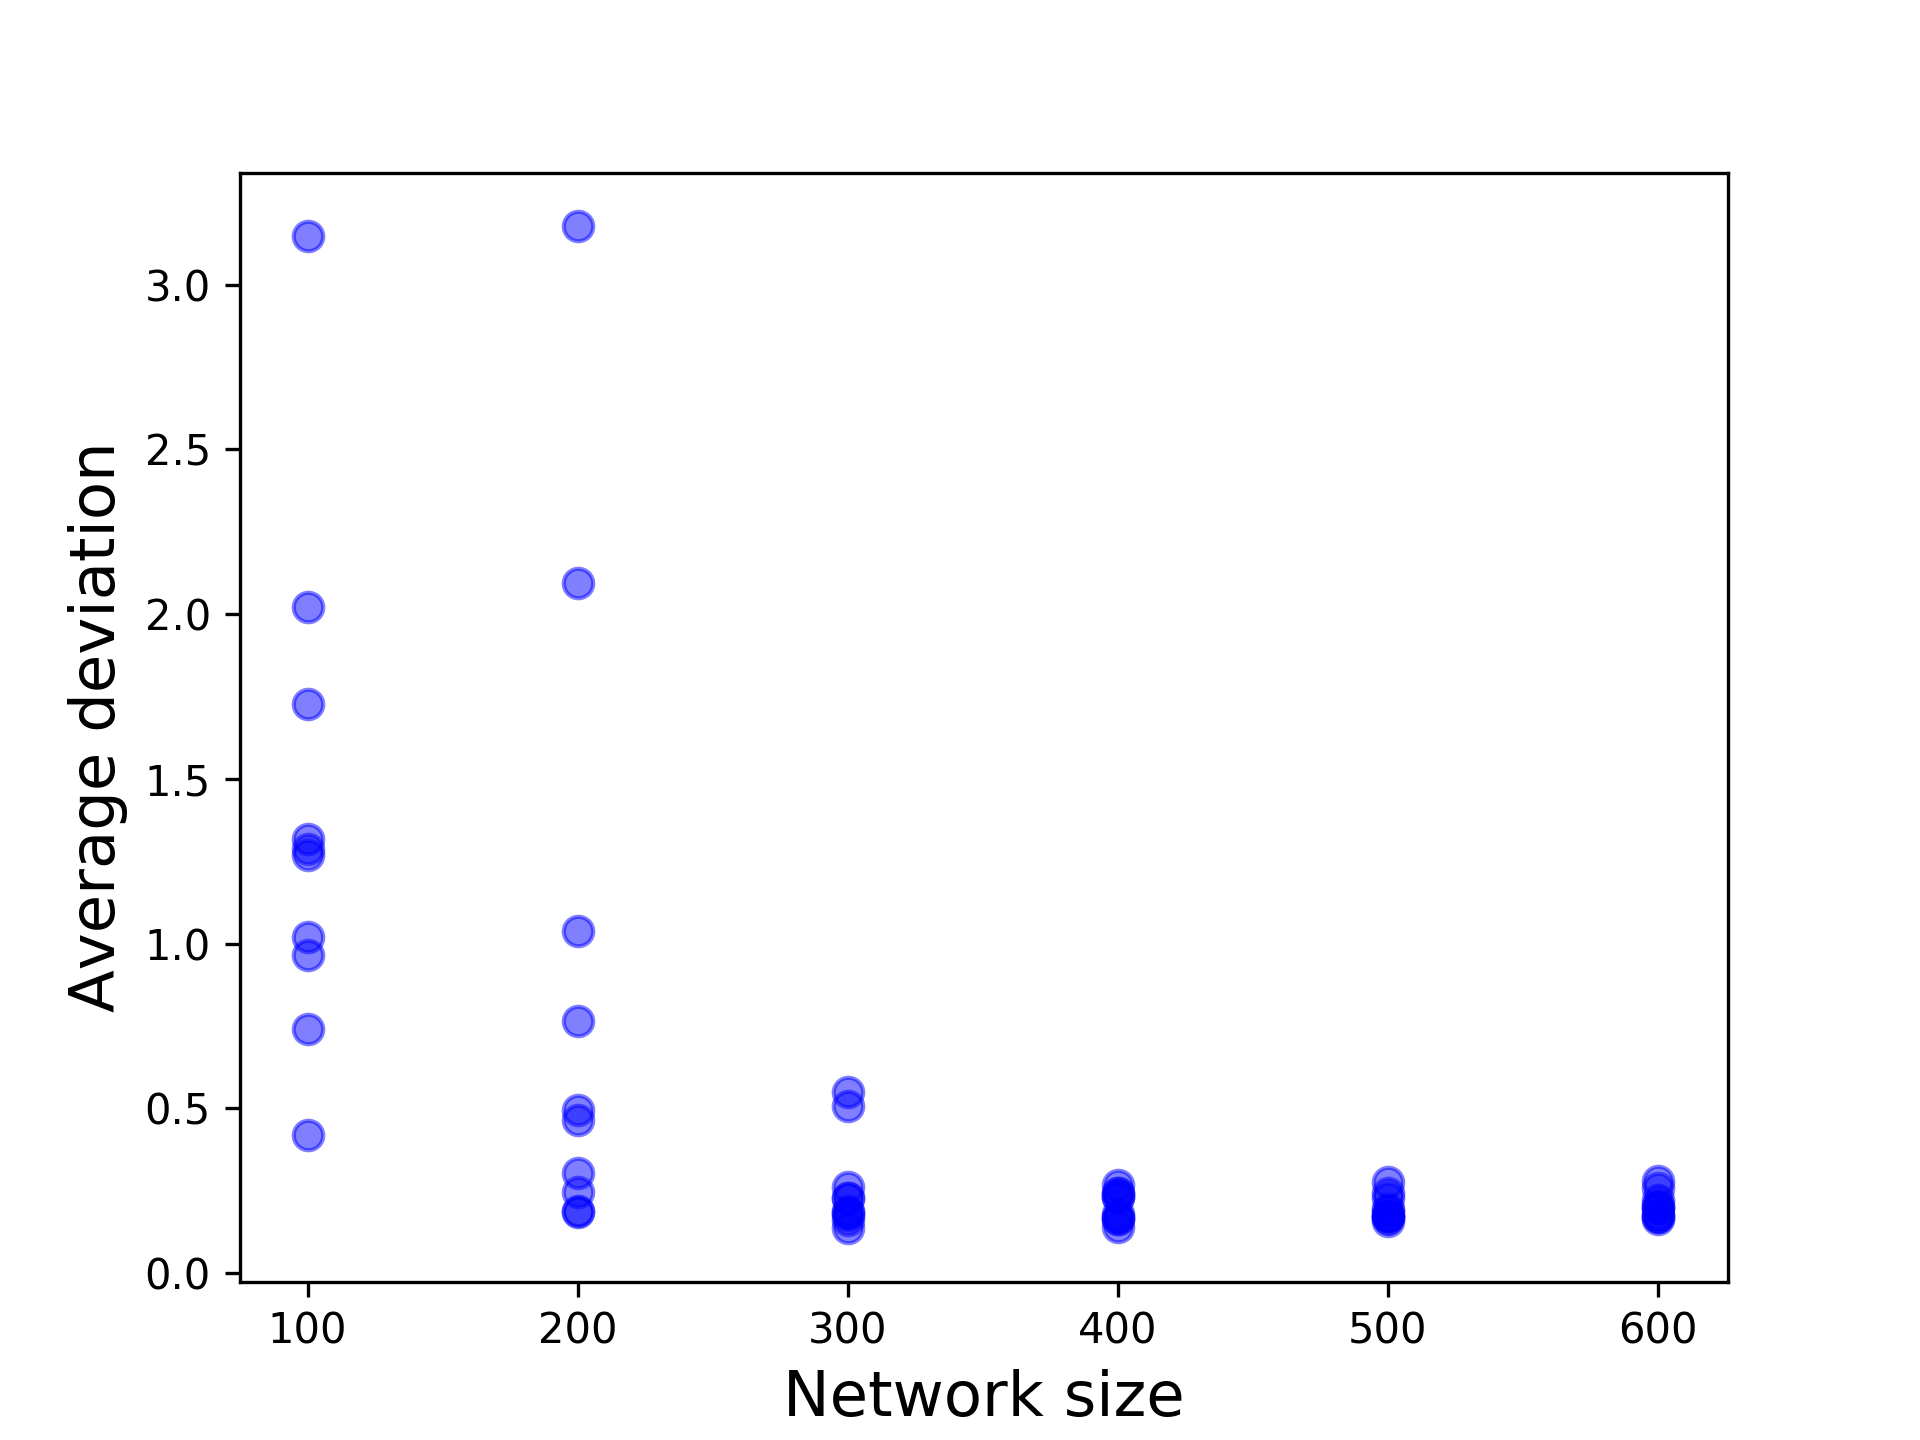

In [32]:
plt.figure()
for i in range(devs.shape[3]):
    plt.scatter((i+1)*100*np.ones(10),devs[0,0,0,i,:], c=[0,0,1], alpha=0.5, s=50)
    
plt.xlabel('Network size', fontsize=15)
plt.ylabel('Average deviation', fontsize=15)

For 6c and 6d, you can use previously generated data (using the saveload function) or re-simulate everything using the commented code. Note that the simulations take quite a while.

In [2]:
from helpers import saveload
devs, gerrs, nphis, kappas, omegas = saveload('load','devs_and_gerrs_Nphi-kappa-omega_2')

In [ ]:
# # Simulating for different numbers of dimensions (num_phis), widths of tuning (kappa), and number of fixed points (omega)
# reps = 10
# devs = np.zeros((6,6,6,1,reps))
# gerrs = np.zeros((6,6,6,1,reps))

# i=0
# for num_phis in [3,4,5,6,7,8]:
#     j=0
#     for kappa in [1,2,3,4,5,6]: #[(num_phis/np.pi)**2]:
#         phis = phi_generator(num_phis=num_phis, kappa=kappa, offset = 0)
#         m=0
#         for omega in [3,4,5,6,7,8]:
#             n=0
#             for N in [400]:
#                 for drift_amp in [0.1]:
#                     for sigma in  [3e-4]:
#                         k=0
#                         for rep in range(reps):
#                             rnn, proj_vecs = get_rnn(phis=phis, omega=omega, drift_amp=drift_amp, 
#                                                      k=144, N=N, radius=12, sigma_reg=sigma, showplots=0)
#                             deviation = analyze_ring(rnn, delay=5, dsec=.005, numthetas=24, showplots=0)
#                             G, G_error=drift_recovery(rnn, proj_vecs, numthetas=144, drift_amp=drift_amp, showplots=0)
#                             devs[i,j,m,n,k] = deviation
#                             gerrs[i,j,m,n,k] = G_error
#                             k+=1
#                 n+=1
#             m+=1
#             print('.', end="")
#         j+=1
#     i+=1
#     print('')
    
# print('Done!')

In [3]:
print(nphis)
print(kappas)
print(omegas)
print(devs.shape)

[3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6]
[3, 4, 5, 6, 7, 8]
(6, 6, 6, 1, 10)


<IPython.core.display.Javascript object>


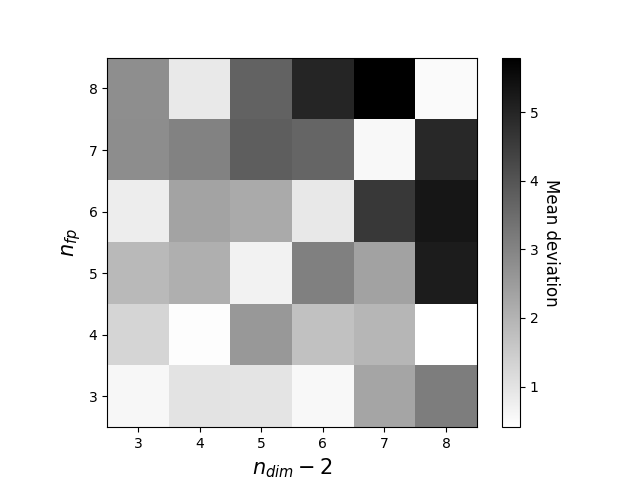

In [35]:
plt.figure()
plt.imshow(np.mean(devs[:,-1,:,0,:], axis=2), origin='lower', extent=[2.5,8.5,2.5,8.5], cmap='binary')
cbar = plt.colorbar()
cbar.set_label('Mean deviation', rotation=270, fontsize=12) #, rotation=270, pad=.5)
cbar.ax.get_yaxis().labelpad=15
plt.xlabel(r'$n_{dim} - 2$', fontsize=15)
plt.ylabel(r'$n_{fp}$', fontsize=15)

<IPython.core.display.Javascript object>


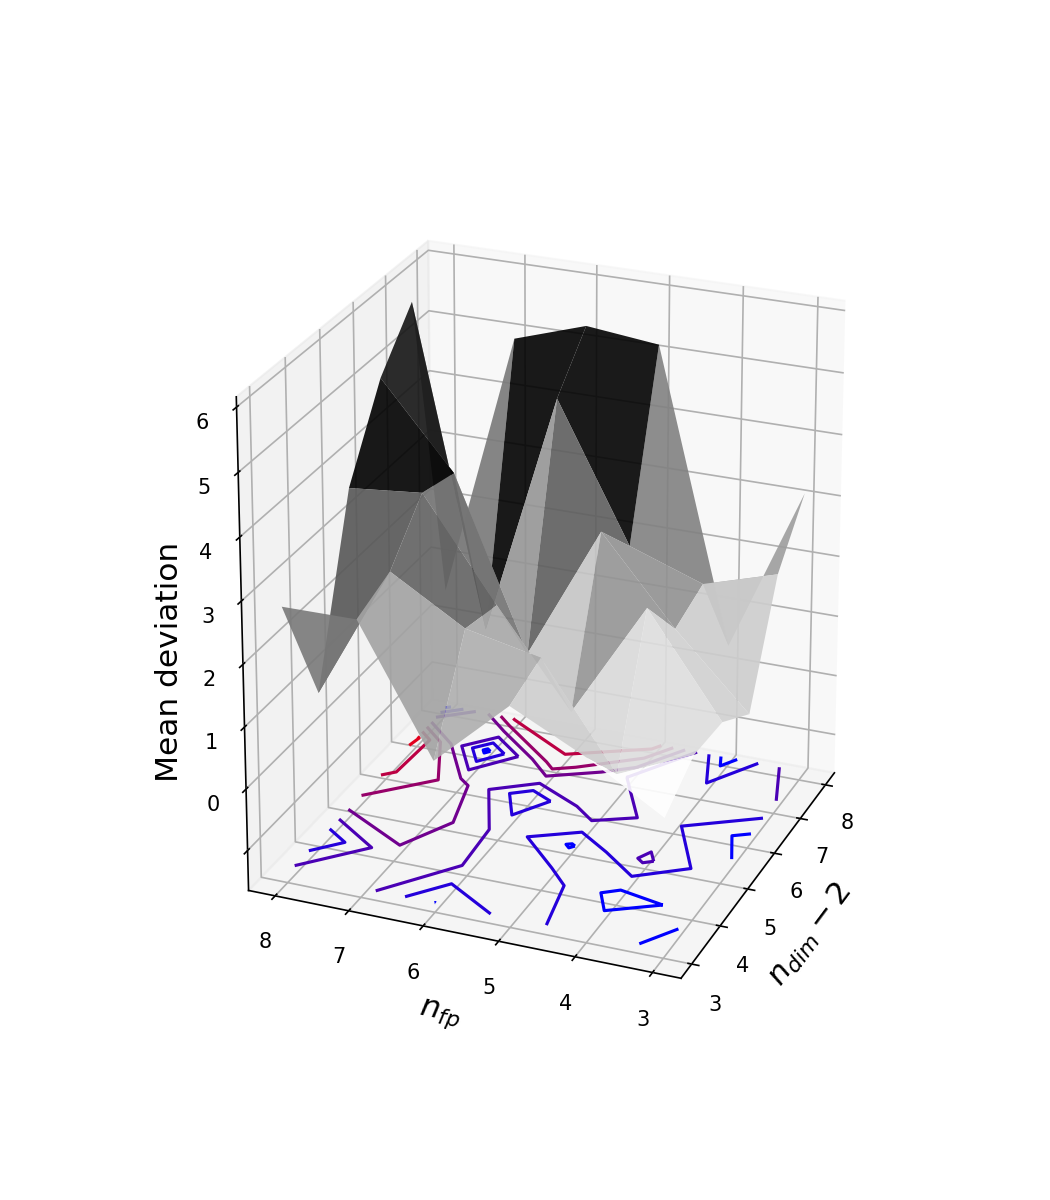

In [13]:
# Alternate view (unused in paper)

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(figsize=(7,8))
ax = fig.gca(projection='3d')
X = np.tile(nphis, (6,1))
Y = X.T
Z = np.mean(devs[:,-1,:,0,:], axis=2)
#Z = devs[:,-1,:,0,:]
cset = ax.contour(X, Y, Z, zdir='z', offset=-1.5, cmap=cm.brg, vmax = np.max(Z)*2)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=.9, cmap= 'binary') #cm.brg, vmax=np.max(Z)*2)

#cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
#cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_zlim([-1.5, 6])
ax.view_init(10,-140)
ax.set_zticklabels(['',0,1,2,3,4,5,6])
plt.xlabel(r'$n_{dim} - 2$', fontsize=15)
plt.ylabel(r'$n_{fp}$', fontsize=15)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('label text', rotation=90)
ax.set_zlabel('Mean deviation', fontsize=15)
plt.show()


<IPython.core.display.Javascript object>


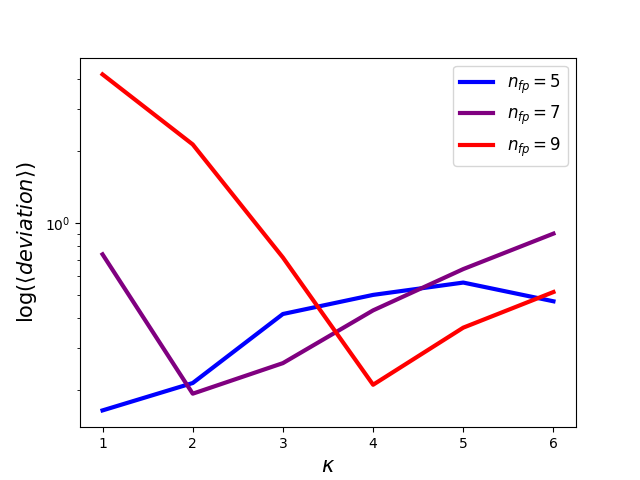

In [6]:
plt.figure()
for i in [1,3,5]:
    plt.semilogy(kappas, np.mean(devs[i,:,i,0,:], axis=1), c=[(i-1)/4,0,1-(i-1)/4], linewidth=3)
    
plt.legend(['$n_{fp} = 5$','$ n_{fp} = 7$','$n_{fp} = 9$'], fontsize=12)
plt.ylabel(r'$\log{(\langle deviation \rangle)}$', fontsize=15)
plt.xlabel(r'$\kappa$', fontsize=15)